# Pumped Hydro-electric Energy Storage

A Pumped Hydro-electric Energy Storage station (PHES) is constituted of two dams, an upper dam (UD) and a lower one (LD). When UD turbines water to LD it produces electical power. When UD pumps water from LD it consumes electrical power. The idea of such a facility is to store energy when electricity is cheap to release it when electricity is expensive. We just described here a rule based heuristic to manage a PHES. The goal of this notebook is to show how to use the Stochastic Dynamic Programming (SDP) and the Stochastic Dual Dynamic Programming (SDDP) algorithm to find how to manage optimally these two storages. The results are compared with the exact solution provided by the extensive formulation that solves the problem on a scenario tree.


<img src=https://upload.wikimedia.org/wikipedia/commons/9/9a/Pumpstor_racoon_mtn.jpg>
<center>source : https://en.wikipedia.org/wiki/Pumped-storage_hydroelectricity</center>

## Mathematical formulation:

Assume that we have a water inflow $w^t$ which arrives in UD between $t$ and $t+1$. This dam pumps a quantity $u_t$ of water when $u_t$ is positive and turbines a quantity $u_t$ of water when u_t is negative. A certain amount of water can be spilt when both dams are full and water inflow positive in UD. $s_t^1$ designates the water spillage in UD. We denote by $x_t^{1}$ and $x_t^{2}$ the state of charge of each storage at time $t$.

Their dynamic are therefor: 

$$ x_{t+1}^1 = x_{t}^1 + w^t + u_t - s_t^1 $$

$$ x_{t+1}^2 = x_{t}^2 - u_t $$

Thus, we could define the state:
$$ X_t = (x_1^t, x_2^t)$$

and the control:
$$U_t = (u_t, s_1) $$

The turbines produce a quantity of electricity proportionnal to the flow turbined, and this electricity is sold into the market at a price $c_t$. We suppose that the buying and the selling costs are equal at each time step. So we pay or gain at each timestep:

$$ C_t(X_t, U_t) = c_t  u_t $$

We want to maximize our expected gains, so we minimize the following quantity:

$$ J = \mathbb{E} \left[ \sum_{i=1}^{T_f} C_t(X_t, U_t) \right]$$ 

## Problem formulation: 

First, we need to import some modules: 

In [2]:
using JuMP, Clp, StochDynamicProgramming, PyCall

using PyPlot

JuMP is the julia module for Mathematical Programming, 
  Clp the module calling a linear solver (can be replaced by CPLEX or Gurobi), 
 StochDynamicProgramming is a Julia module containing SDP and SDDP algorithms, 
 Gadfly is used here for plotting the results 
 

---
### Constants definition

Then, we define the constants of this problem: 

In [3]:
# Number of timesteps (as we manage the dams over a year, it is equal to the number of weeks):
TF = 3

# Capacity of dams: 
VOLUME_MAX = 30
VOLUME_MIN = 0

# Specify the maximum flow of turbines: 
CONTROL_MAX = 20
CONTROL_MIN = -20

# Some statistics about aleas (water inflow):
W_MAX = 15
W_MIN = 0
DW = 1

T0 = 1

# Define aleas' space:
N_ALEAS = Int(round(Int, (W_MAX - W_MIN) / DW + 1))
ALEAS = linspace(W_MIN, W_MAX, N_ALEAS);


Now, we generate a random process to simulate the evolution of electricity prices over a year: 

In [4]:
COST = 66*2.7*(1 + .5*(rand(TF-1) - .5));


We could plot the evolution of prices using matplotlib: 

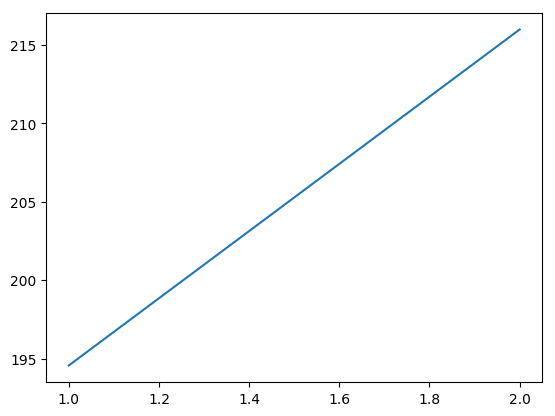

In [6]:
plot(1:TF-1, COST);

---
### Dynamic, costs and aleas


---

We could now define the dynamic of our system: 

In [7]:
# Define dynamic of the dam:
function dynamic(t, x, u, w)
    return [x[1] + u[1] + w[1] - u[2], x[2] - u[1]]
end

dynamic (generic function with 1 method)

and the cost at time $t$:

In [9]:
# Define cost corresponding to each timestep:
function cost_t(t, x, u, w)
    return COST[t] * (u[1])
end

cost_t (generic function with 1 method)

Now, we build a function to simulate the evolution of water inflow $w_t$.




In [10]:
"""Build admissible scenarios for water inflow over the time horizon."""
function build_scenarios(n_scenarios::Int64, n_stages)
    scenarios = zeros(n_scenarios, n_stages)

    for scen in 1:n_scenarios
        scenarios[scen, :] = (W_MAX-W_MIN)*rand(n_stages)+W_MIN
    end
    return scenarios
end


build_scenarios (generic function with 1 method)

We could test our generator with one scenario: 

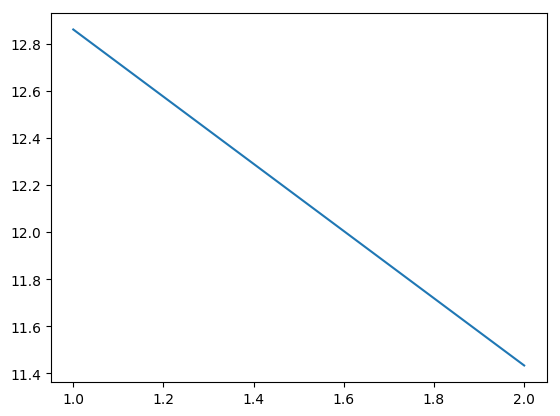

In [11]:
scenario = build_scenarios(1, TF-1);

plot(1:TF-1,scenario');

---
To use these scenarios in SDDP, we must use a discrete distribution for each timestep. The following function generates `n_scenarios` and returns a vector of `NoiseLaw` corresponding to the evolution of aleas distribution along the time: 

In [12]:
"""Build probability distribution at each timestep based on N scenarios.

Return a Vector{NoiseLaw}"""
function generate_probability_laws(N_STAGES, N_SCENARIOS)
    aleas = zeros(N_SCENARIOS, N_STAGES, 1)
    aleas[:, :, 1] = build_scenarios(N_SCENARIOS, N_STAGES)

    laws = Vector{NoiseLaw}(N_STAGES)

    # uniform probabilities:
    proba = 1/N_SCENARIOS*ones(N_SCENARIOS)

    for t=1:N_STAGES
        aleas_t = reshape(aleas[:, t, :], N_SCENARIOS, 1)'
        laws[t] = NoiseLaw(aleas_t, proba)
    end

    return laws
end

generate_probability_laws (generic function with 1 method)

---

## Solving the problem with SDDP

### SDDP model

We generate 10 scenarios and fit a probability distribution at each timestep: 

In [13]:
N_SCENARIO = 10
aleas = generate_probability_laws(TF-1, 10);

---
We define the bounds over the state and the control:

In [15]:
x_bounds = [(VOLUME_MIN, VOLUME_MAX), (VOLUME_MIN, VOLUME_MAX)];
u_bounds = [(CONTROL_MIN, CONTROL_MAX), (VOLUME_MIN, VOLUME_MAX)];

and the initial position $X_0$:

In [16]:
x0 = [15, 15]

2-element Array{Int64,1}:
 15
 15

We build an instance of `LinearDynamicLinearCostSPModel` to translate our problem in SDDP: 

In [17]:
model = LinearSPModel(TF, # number of timestep
                                        u_bounds, # control bounds
                                        x0, # initial state
                                        cost_t, # cost function
                                        dynamic, # dynamic function 
                                        aleas);
set_state_bounds(model, x_bounds);


---
### SDDP parameters

We define the parameters of the algorithm: 

In [19]:
# LP solver: 
solver = ClpSolver()
# Precision of the algorithm in percent: 
EPSILON = 0.05
# Maximum iterations: 
MAX_ITER = 20


params = SDDPparameters(solver, passnumber=N_SCENARIO, gap=EPSILON, max_iterations=MAX_ITER);

---
### SDDP solving

We could launch the SDDP algorithm to our problem: 

In [20]:
V, pbs = solve_SDDP(model, params, 1);

Initial value function loaded into memory.
Initialize cuts
Pass number 1	Lower-bound: -3346.76	Time: 0.08s
Pass number 2	Lower-bound: -3346.76	Time: 0.03s
Pass number 3	Lower-bound: -3346.76	Time: 0.03s
Pass number 4	Lower-bound: -3346.76	Time: 0.03s
Pass number 5	Lower-bound: -3346.76	Time: 0.03s
Pass number 6	Lower-bound: -3346.76	Time: 0.03s
Pass number 7	Lower-bound: -3346.76	Time: 0.04s
Pass number 8	Lower-bound: -3346.76	Time: 0.04s
Pass number 9	Lower-bound: -3346.76	Time: 0.04s
Pass number 10	Lower-bound: -3346.76	Time: 0.04s
Pass number 11	Lower-bound: -3346.76	Time: 0.04s
Pass number 12	Lower-bound: -3346.76	Time: 0.05s
Pass number 13	Lower-bound: -3346.76	Time: 0.05s
Pass number 14	Lower-bound: -3346.76	Time: 0.04s
Pass number 15	Lower-bound: -3346.76	Time: 0.04s
Pass number 16	Lower-bound: -3346.76	Time: 0.05s
Pass number 17	Lower-bound: -3346.76	Time: 0.04s
Pass number 18	Lower-bound: -3346.76	Time: 0.04s
Pass number 19	Lower-bound: -3346.76	Time: 0.05s
Pass number 20	Lowe

The algorithm returns the bellman functions (`V`) and a vector of `JuMP.Model` used to approximate these functions with linear cuts. 



---
## Test SDDP with an example 

### Input scenario

We suppose given a scenario of inflows: 


In [21]:
alea_year = Array([7.0 7.0])


1x2 Array{Float64,2}:
 7.0  7.0

We store this scenario as a 3D array, so it could be used to compute a forward-pass:

In [22]:
aleas_scen = zeros(2, 1, 1)
aleas_scen[:, 1, 1] = alea_year;


---
### SDDP simulation

We have only one scenario, so we set the forwardPassNumber equal to 1: 

Find the optimal control with a forward simulation: 

In [24]:
costs, stocks = forward_simulations(model, params, pbs, aleas_scen);

---
### Results 

The cost is: 

In [25]:
SDDP_COST = costs[1]
println("SDDP cost: ", SDDP_COST)

SDDP cost: -3346.7599768405644


And the optimal solution is: 

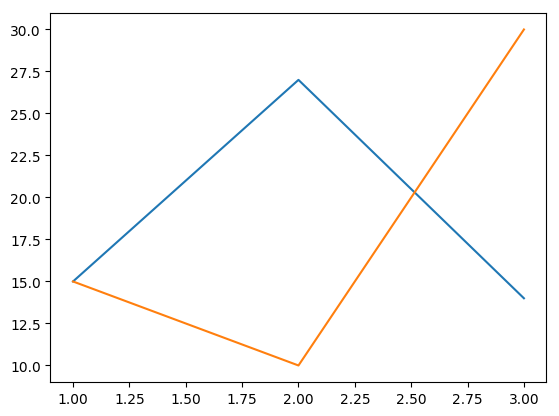

In [28]:
plot(1:TF, stocks[:, :, 1])
plot(1:TF, stocks[:, :, 2]);

---
## Comparison with the deterministic solution 
To check the results given by SDDP, we solve the deterministic problem with JuMP: 

In [29]:
m = Model(solver=solver)


@variable(m,  VOLUME_MIN  <= x1[1:(TF)]  <= VOLUME_MAX)
@variable(m,  VOLUME_MIN  <= x2[1:(TF)]  <= VOLUME_MAX)
@variable(m,  CONTROL_MIN <= u1[1:TF-1]  <= CONTROL_MAX)
@variable(m, VOLUME_MIN  <= u2[1:TF-1] <= VOLUME_MAX)

@objective(m, Min, sum{COST[i]*(u1[i]), i = 1:TF-1})

for i in 1:TF-1
    @constraint(m, x1[i+1] - x1[i] - u1[i] + u2[i] - alea_year[i] == 0)
    @constraint(m, x2[i+1] - x2[i] + u1[i] == 0)
end

@constraint(m, x1[1] == x0[1])
@constraint(m, x2[1] == x0[2])

status = solve(m)
println(status)

LP_COST = getobjectivevalue(m)
println("LP value: ", LP_COST)

Optimal
LP value: -3346.759976840564


And we plot the evolution of the stocks:

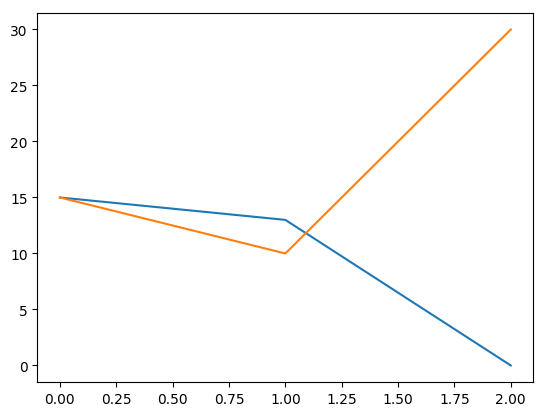

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f371a34cf10>

In [30]:
plot(getvalue(x1))
plot(getvalue(x2))

The solution given by the solver is more optimistic, as it assumes that the future is known in advance. 

If we consider the costs, we have a discrepancy between the two solutions :


In [31]:
abs((LP_COST - SDDP_COST)/LP_COST)


1.3587689408063213e-16

## Comparison with SDP 
To check the results given by SDDP, we solve the stochastic problem with SDP: 

We define constants necessary for SDP

In [32]:
N_CONTROLS = 2;
N_STATES = 2;
N_NOISES = 1;

We have to define a constraint function as SDP may take into account mixed state and control constraints

In [33]:
function constraints(t, x, u, w)
    return true
end


constraints (generic function with 1 method)

We define a final cost function as well

In [34]:
function finalCostFunction(x)
    return 0.
end

finalCostFunction (generic function with 1 method)

In [35]:
modelSDP = StochDynProgModel(TF,
                    x_bounds, u_bounds,
                    x0, cost_t,
                    finalCostFunction, dynamic,
                    constraints, aleas);

We define some parameters needed by SDP : states and controls discretization and monte carlo sampling size

In [36]:
stateSteps = [1,1];
controlSteps = [1,1];
monteCarloSize = 10;

We have to define wether the controls are chosen knowing the uncertainty realization (hazard-decision) or prior 
to know the uncertainty realization (decision-hazard). We chose here hazard decision to compare with SDDP.

In [37]:
infoStruct = "HD";

Let's define the parameters of the algorithm 

In [38]:
paramsSDP = SDPparameters(modelSDP, stateSteps, controlSteps,  infoStruct, "Exact", monteCarloSize);

We are ready to produce the value functions

In [39]:
V_sdp = solve_DP(modelSDP, paramsSDP, true);

[SDP] Starting value functions computation:


Thanks to these value functions we are now able to compute a forward simulation with the same scenario

In [40]:
costs_sdp, stocks_sdp, controls_sdp = sdp_forward_simulation(modelSDP, paramsSDP, aleas_scen, V_sdp, true );

We can compare this result to the deterministic one and SDDP one

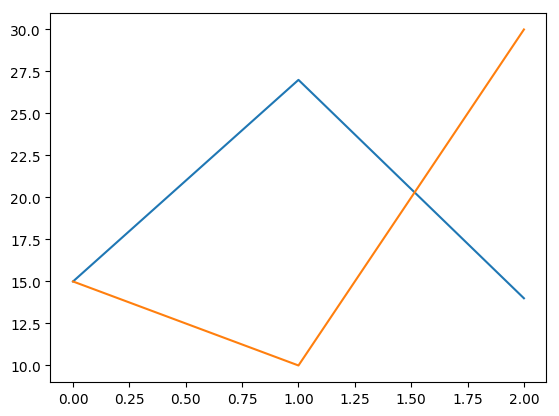

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f371a2a1550>

In [41]:
plot(stocks_sdp[:,:,1])
plot(stocks_sdp[:,:,2])

In [42]:
abs((costs_sdp - SDDP_COST)/costs_sdp)

1x1 Array{Float64,2}:
 1.35877e-16

In [43]:
abs((costs_sdp - LP_COST)/LP_COST)

1-element Array{Float64,1}:
 0.0

## Comparison with the Extensive Formulation 
We now compare the results with the Extensive Formulation

In [44]:
costs_EF, EFstatus = extensive_formulation(model,params)

(-3346.7599768405594,[-20.0,-20.0,-20.0,9.864126983174742,-20.0,0.0,10.82494695466485,0.0,1.2527875210460735,-20.0,-20.0,5.0,-20.0,0.0,-20.0,-20.0,-20.0,0.0,0.0,0.0],:Optimal)

In [45]:
abs((costs_EF - SDDP_COST)/costs_EF)

1.4946458348869553e-15

In [46]:
abs((costs_EF - costs_sdp)/costs_EF)

1-element Array{Float64,1}:
 1.35877e-15